In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import plotly.express as px
from numpy import array
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import string
from nltk.corpus import stopwords #important content
from nltk.stem.porter import PorterStemmer #take rootword
from sklearn.feature_extraction.text import TfidfVectorizer #convert text to feature vectors
from wordcloud import WordCloud
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

2024-05-08 13:45:26.700723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 13:45:26.700823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 13:45:26.994762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', nrows=20000)

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Shuffle the dataframe to ensure the rows are randomly selected
df = df.sample(frac=1).reset_index(drop=True)

**Data** **Preprocessing**

In [8]:
df.shape

(20000, 2)

In [9]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [10]:
df['word count'] = df['review'].apply(no_of_words)

In [11]:
# Words to remove
words_to_remove = ['movi', 'film', 'one']

# Removing the words from the review column
for word in words_to_remove:
    df['review'] = df['review'].str.replace(word, '')

In [12]:
df.head()

,review,sentiment,word count
0,"This is without a doubt of the worst es EVER,...",negative,140
1,This caught me by surprise. My friend told me...,positive,111
2,"I have seen s come and go in my years,and when...",positive,207
3,Hollywood always had trouble coming to terms w...,negative,222
4,"Typically, ""kids"" s have some annoying quality...",positive,153


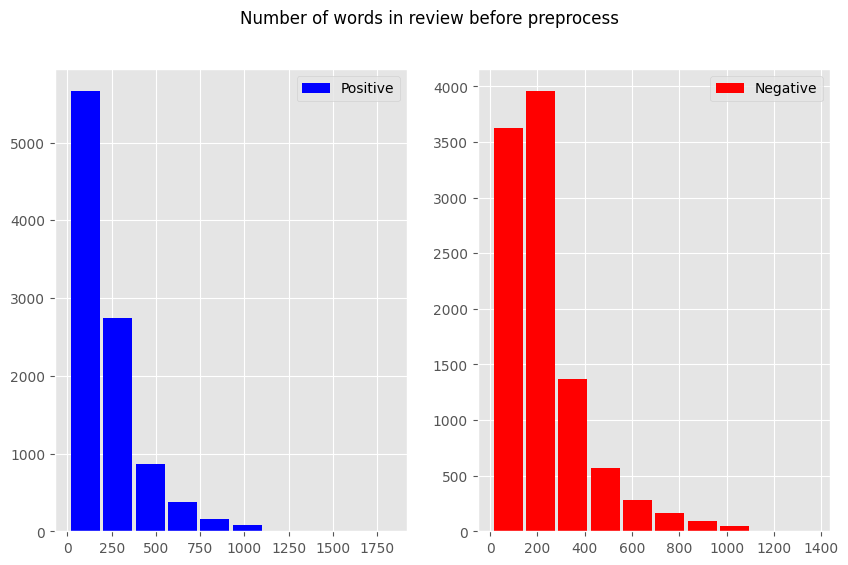

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review before preprocess")
plt.show()

In [14]:
df.head()

,review,sentiment,word count
0,"This is without a doubt of the worst es EVER,...",negative,140
1,This caught me by surprise. My friend told me...,positive,111
2,"I have seen s come and go in my years,and when...",positive,207
3,Hollywood always had trouble coming to terms w...,negative,222
4,"Typically, ""kids"" s have some annoying quality...",positive,153


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      20000 non-null  object
 1   sentiment   20000 non-null  object
 2   word count  20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [16]:
df.isnull().values.any()

False

In [17]:
df['review'].isnull().sum()

0

In [18]:
df['review'].duplicated().sum()

74

In [19]:
df = df.drop_duplicates(subset=['review'])

In [20]:
df['review'].duplicated().sum()

0

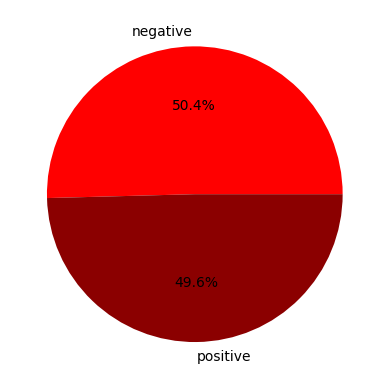

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pie chart
plt.pie(df["sentiment"].value_counts(), labels=df["sentiment"].unique(), autopct="%1.1f%%", colors=["red", "darkred"])

# Display both plots
plt.show()

In [22]:
df["review"][3]

'Hollywood always had trouble coming to terms with a "religious picture." Strange Cargo proves to be no exception. Although utilizing the talents of a superb cast, and produced on a top budget, with suitably moody photography by Robert Planck, the e fails dismally on the credibility score. Perhaps the reason is that the  seems so realistic that the sudden intrusion of fantasy elements upsets the viewer\'s involvement in the action and with the fate of the characters. I found it difficult to sit still through all the contrived metaphors, parallels and biblical references, and impossible to accept bathed-in-light Ian Hunter\'s smug know-it-all as a Christ figure. And the censors in Boston, Detroit and Providence at least agreed with me. The e was banned. Few Boston/Detroit/Providence egoers, if any, complained or journeyed to other cities because it was obvious from the trailer that Gable and Crawford had somehow become involved in a "message picture." It flopped everywhere.<br /><br />O

In [23]:
port_stem = PorterStemmer()

In [24]:
def stemming(review): #function to take root word of each word in the content and return the content
    stemmed_review = re.sub('[^a-zA-Z]', ' ',review) #remove all characters except a-z and A-Z words                                vitahrai symbol eva ain krnna symbol eva tynva eva space venva "" content kynne doc eke combine krnna
    stemmed_review = re.sub(r'http\S+', '', stemmed_review) #remove urls
    stemmed_review = stemmed_review.lower() #convert all characters to lower case
    stemmed_review = stemmed_review.split() #split the content into words list
    stemmed_review = [port_stem.stem(word) for word in stemmed_review if not word in stopwords.words('english')] #take root word of each word main word ganne stopwords eka ain krnva
    stemmed_review= ' '.join(stemmed_review) #join the words to form a sentence
    stemmed_review = re.sub(r'\s\s+', ' ', stemmed_review) #remove extra spaces
    stemmed_review = re.sub(r'\d+', '', stemmed_review) #remove digits
    stemmed_review = re.sub(r'[^\w\s]', '', stemmed_review) #remove punctuation
    stemmed_review = re.sub(r'b\s+', '', stemmed_review) #remove single characters

    return stemmed_review

In [25]:
df['review'] = df['review'].apply(stemming)

In [26]:
df.head()

,review,sentiment,word count
0,without doubt worst es ever emphas ever made w...,negative,140
1,caught surpris friend told e chick flick boy w...,positive,111
2,seen come go year see disast keep hope wont di...,positive,207
3,hollywood alway troubl come term religi pictur...,negative,222
4,typic kid annoy qualiti make way sappi unbear ...,positive,153


In [27]:
def remove_single(review):
    # Define a pattern to match single or two-character words
    pattern = r'\b\w{1,2}\b'  # \b indicates word boundaries, \w{1,2} matches one or two word characters

    # Use re.sub() to replace matched patterns with an empty string
    cleaned_review = re.sub(pattern, '', review)

    return cleaned_review

In [28]:
df['review'] = df['review'].apply(remove_single)

In [29]:
df.head(5)

,review,sentiment,word count
0,without doubt worst ever emphas ever made wor...,negative,140
1,caught surpris friend told chick flick boy wr...,positive,111
2,seen come year see disast keep hope wont disa...,positive,207
3,hollywood alway troubl come term religi pictur...,negative,222
4,typic kid annoy qualiti make way sappi unbear ...,positive,153


In [30]:
import re

def strip_html(text):
    # Regular expression to match HTML tags
    html_tags = re.compile(r'<[^>]+>')
    # Remove HTML tags from the text using regex
    return html_tags.sub('', text)

def remove_between_square_brackets(text):
    # Regular expression to match text between square brackets
    square_brackets = re.compile(r'\[[^]]*\]')
    # Remove text between square brackets using regex
    return square_brackets.sub('', text)

def denoise_text(review):
    text = strip_html(review)
    text = remove_between_square_brackets(text)  # Fixed the argument here
    return text

# Apply function on the review column of DataFrame 'df'
df['review'] = df['review'].apply(denoise_text)

In [31]:
df.head()

,review,sentiment,word count
0,without doubt worst ever emphas ever made wor...,negative,140
1,caught surpris friend told chick flick boy wr...,positive,111
2,seen come year see disast keep hope wont disa...,positive,207
3,hollywood alway troubl come term religi pictur...,negative,222
4,typic kid annoy qualiti make way sappi unbear ...,positive,153


In [32]:
df.sentiment.replace("positive", 1, inplace = True)
df.sentiment.replace("negative", 0, inplace = True)

/tmp/ipykernel_34/3523318407.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sentiment.replace("positive", 1, inplace = True)
/tmp/ipykernel_34/3523318407.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [33]:
df.head()

,review,sentiment,word count
0,without doubt worst ever emphas ever made wor...,0,140
1,caught surpris friend told chick flick boy wr...,1,111
2,seen come year see disast keep hope wont disa...,1,207
3,hollywood alway troubl come term religi pictur...,0,222
4,typic kid annoy qualiti make way sappi unbear ...,1,153


In [34]:
pos_reviews = df[df.sentiment ==1]
pos_reviews.head()

,review,sentiment,word count
1,caught surpris friend told chick flick boy wr...,1,111
2,seen come year see disast keep hope wont disa...,1,207
4,typic kid annoy qualiti make way sappi unbear ...,1,153
5,good time groundbreak comedi first nuclear bla...,1,178
6,excel thought origin quiet mediocr howev got i...,1,64


In [35]:
from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(10)

[('like', 8048),
 ('time', 6500),
 ('good', 6063),
 ('see', 5907),
 ('stori', 5570),
 ('charact', 5455),
 ('make', 5374),
 ('well', 5147),
 ('great', 5121),
 ('watch', 5079)]

In [36]:
neg_reviews = df[df.sentiment == 0]
neg_reviews.head()

,review,sentiment,word count
0,without doubt worst ever emphas ever made wor...,0,140
3,hollywood alway troubl come term religi pictur...,0,222
7,use random event histor signific backdrop wil...,0,362
9,obvious good intent end dedic name kelli view...,0,393
11,proof redbox read descript pick give tri g...,0,123


In [37]:
count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] += 1
count.most_common(10)

[('like', 9846),
 ('make', 6640),
 ('get', 6309),
 ('even', 6206),
 ('time', 6128),
 ('good', 6055),
 ('bad', 5968),
 ('watch', 5821),
 ('would', 5684),
 ('charact', 5673)]

In [38]:
df.head()

,review,sentiment,word count
0,without doubt worst ever emphas ever made wor...,0,140
1,caught surpris friend told chick flick boy wr...,1,111
2,seen come year see disast keep hope wont disa...,1,207
3,hollywood alway troubl come term religi pictur...,0,222
4,typic kid annoy qualiti make way sappi unbear ...,1,153


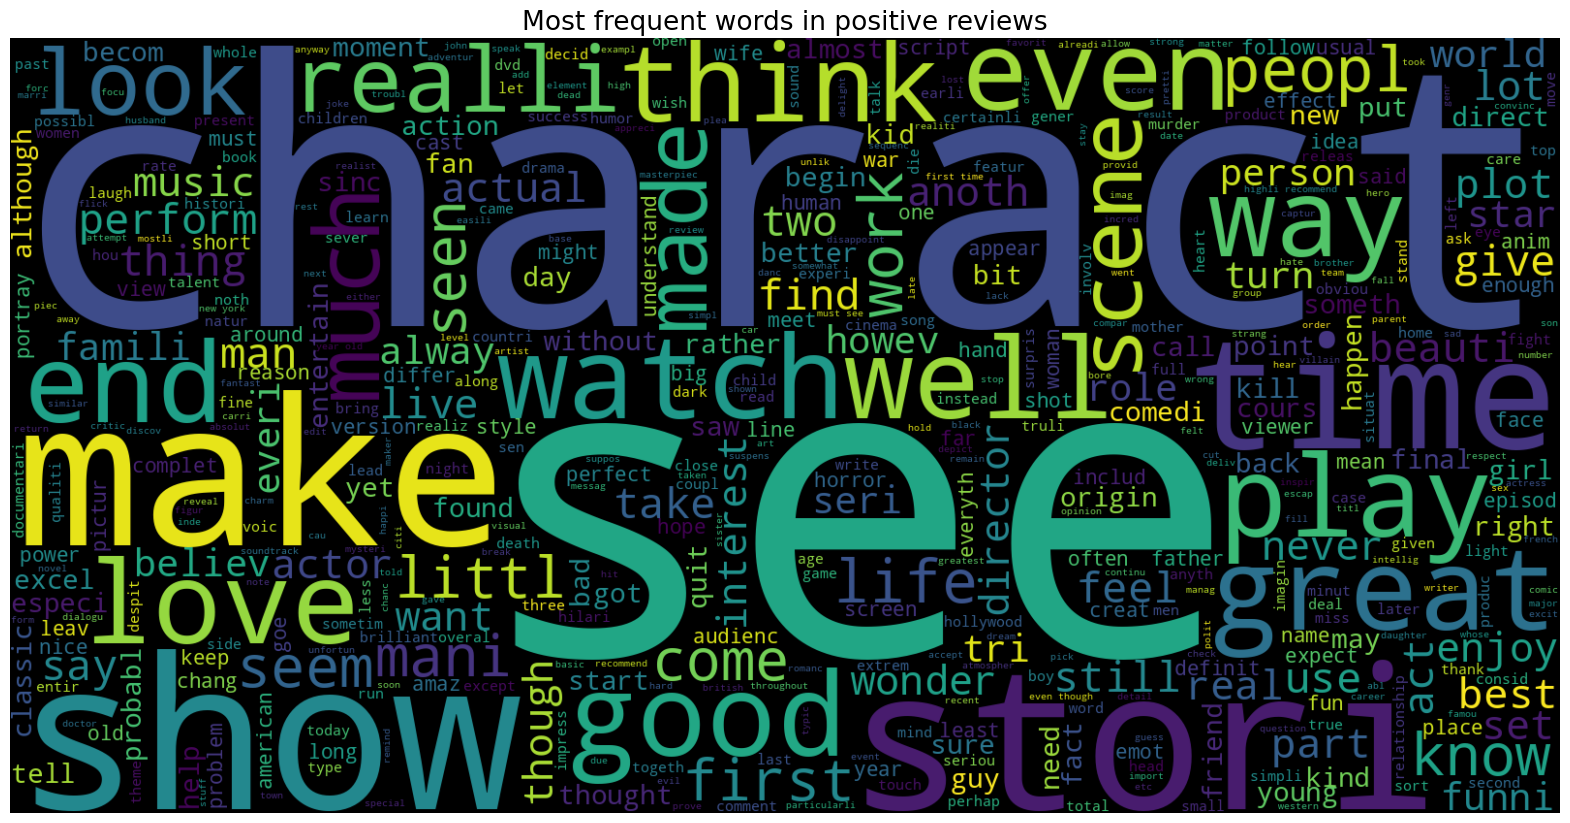

In [39]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [40]:
pos_words = pd.DataFrame(count.most_common(10))
pos_words.columns = ['word', 'count']
pos_words.head()

,word,count
0,like,9846
1,make,6640
2,get,6309
3,even,6206
4,time,6128


In [41]:
px.bar(pos_words, x='count', y='word', title='Frequent words in positive reviews', color='word')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


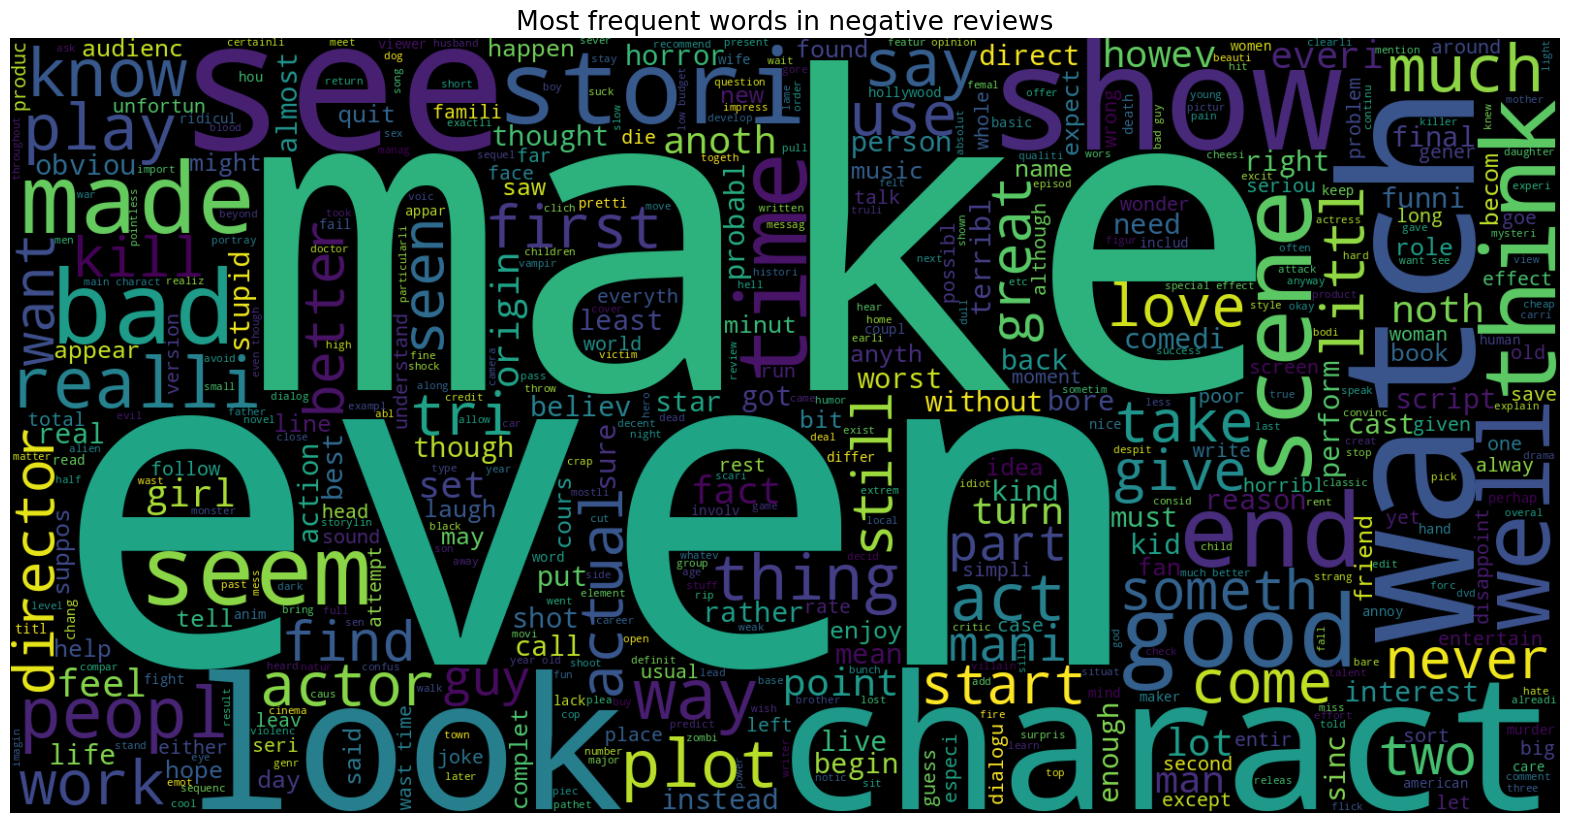

In [42]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

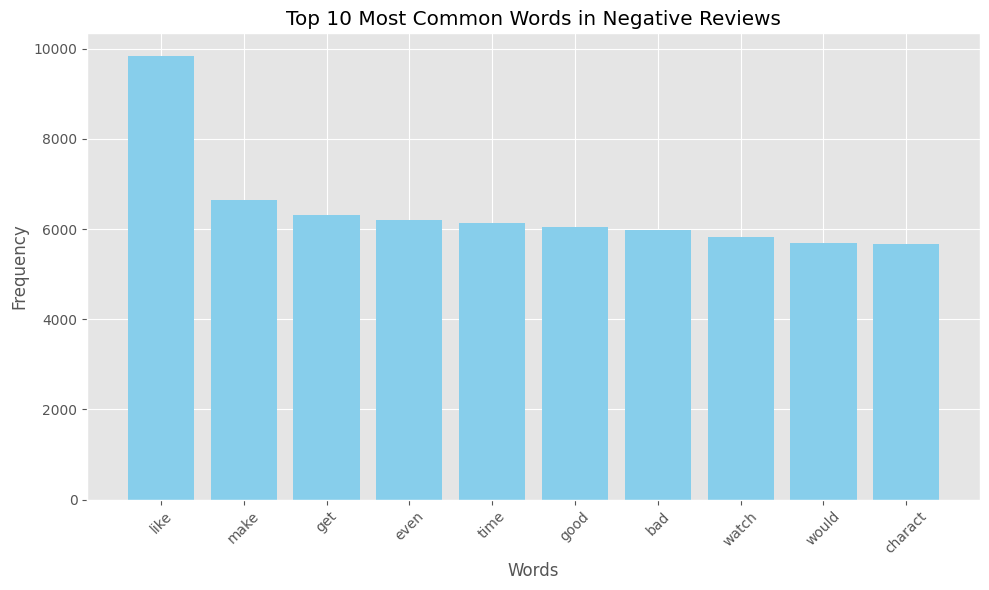

In [43]:
top_10_words = count.most_common(10)

# Extract words and their counts
words, counts = zip(*top_10_words)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Common Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [45]:
# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Calling Function 
df['review'] = df['review'].apply(chat_conversion)

In [46]:
df.head(5)

,review,sentiment,word count
0,without doubt worst ever emphas ever made wors...,0,140
1,caught surpris friend told chick flick boy wro...,1,111
2,seen come year see disast keep hope wont disap...,1,207
3,hollywood alway troubl come term religi pictur...,0,222
4,typic kid annoy qualiti make way sappi unbear ...,1,153


### Splitting the data

In [47]:
X = df['review']
Y = df['sentiment']

In [48]:
vect = TfidfVectorizer() #Feature extraction using TF-IDF
X = vect.fit_transform(df['review'])

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [50]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (13948, 54738)
Size of y_train:  (13948,)
Size of x_test:  (5978, 54738)
Size of y_test:  (5978,)


In [51]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [52]:
from keras.models import Sequential


In [53]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [54]:
from tensorflow.keras.optimizers import Adam

# Then you can use it in your model compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(x_train, y_train, batch_size=15, epochs=20)

Epoch 1/20
 46/930 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5453 - loss: 0.6909

I0000 00:00:1715176728.661882     140 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715176728.676840     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


930/930 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7959 - loss: 0.4699
Epoch 2/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9689 - loss: 0.1002
Epoch 3/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9947 - loss: 0.0284
Epoch 4/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9983 - loss: 0.0094
Epoch 5/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9998 - loss: 0.0017
Epoch 6/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 5.5582e-04
Epoch 7/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 2.4558e-04
Epoch 8/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.3758e-04
Epoch 9/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 5.8423e-05
Epoch 10/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 3.1557e-05
Epoch 11/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 2.4744e-05
Epoch 12/20
930/930 ━━━━━━━━━━━━━━━━━━━

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │     1,751,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,256,581 (20.05 MB)

 Trainable params: 1,752,193 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,504,388 (13.37 MB)

In [57]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8548 - loss: 1.1815
Test loss: 1.1216920614242554
Test accuracy: 0.8621612787246704


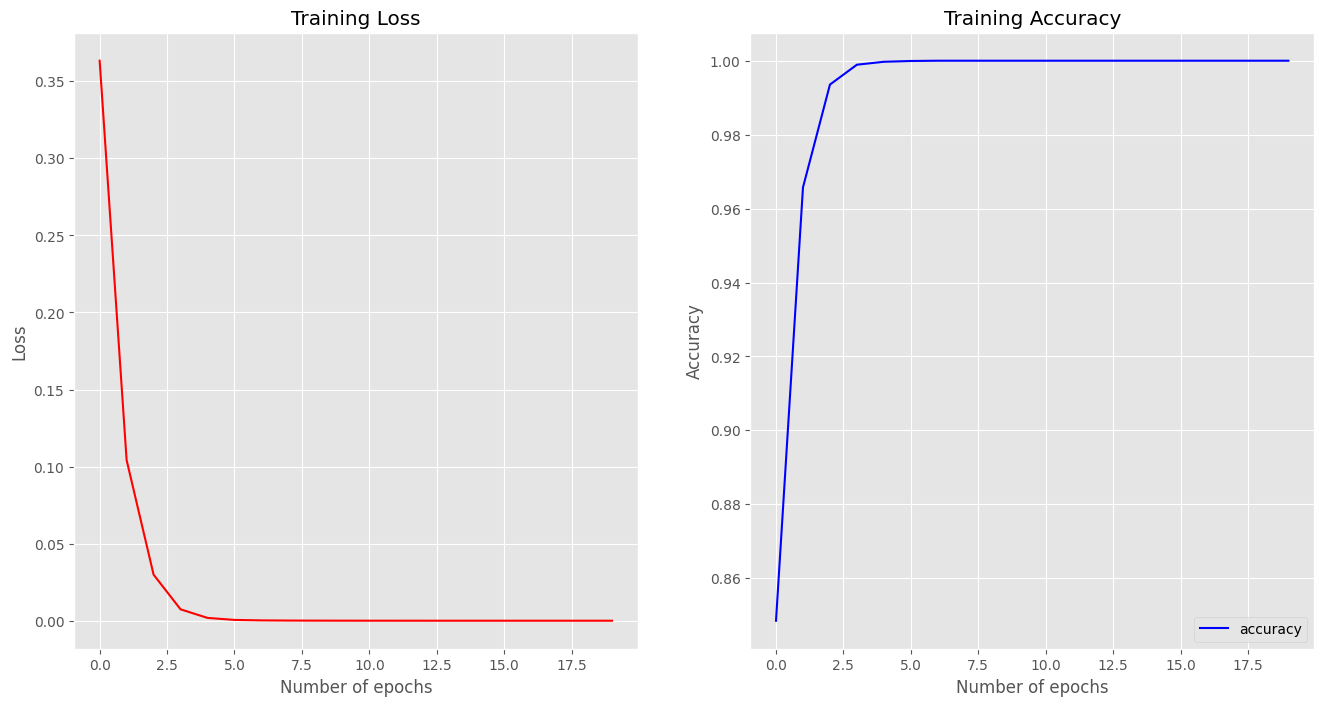

In [58]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r', label='loss')
plt.title('Training Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.title('Training Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


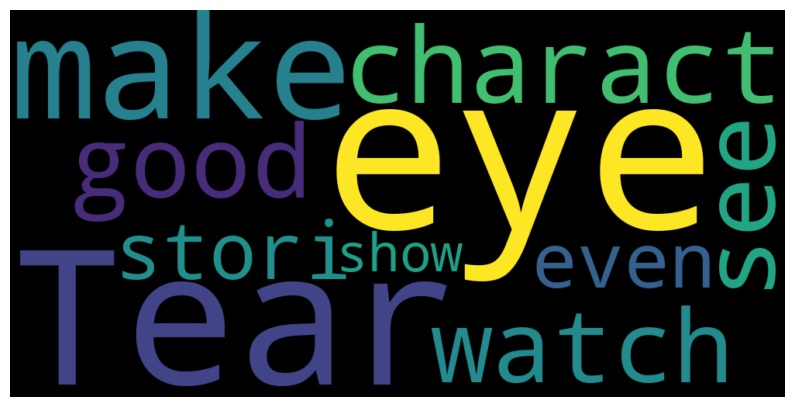

In [59]:
# Obtain predicted probabilities on the test set
y_pred_prob = model.predict(x_test)

# Convert predicted probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Filter out positive reviews
positive_reviews = []
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        positive_reviews.append(df['review'].iloc[i])

positive_text = ' '.join(positive_reviews)

plt.figure(figsize=(10, 10))
WC = WordCloud(width=1000, height=500, max_words=10, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [60]:
y_pred = model.predict(x_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [61]:
y_pred

array([[2.8645543e-06],
       [4.7703244e-11],
       [1.2604194e-09],
       ...,
       [9.9999952e-01],
       [2.6625846e-04],
       [2.0429561e-02]], dtype=float32)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you have predictions from your model stored in y_pred
# Assuming y_test contains actual sentiment labels

# Calculate accuracy
# Convert continuous predictions to binary class labels
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)


Accuracy: 0.8621612579458012


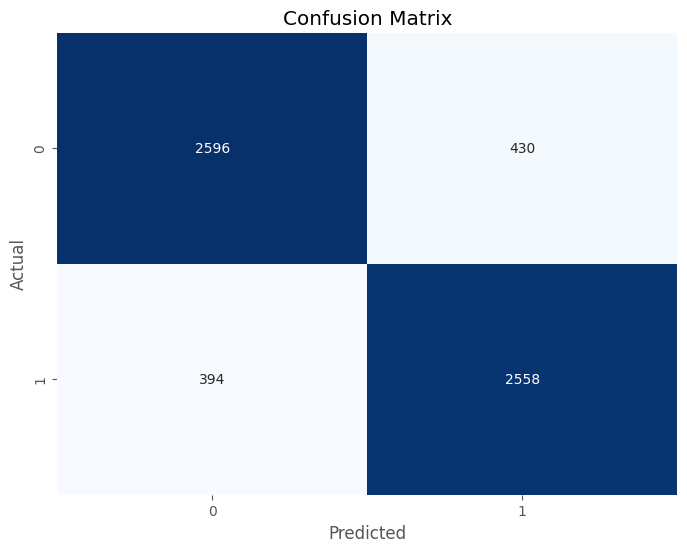

In [63]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()